## Ecoli dataset classification

Informations on the dataset:
* Name: ecoli.csv
* X1 to X5 - Features of the proteins.
* C - Class. This is the location of the protein. A value of 0 refers to proteins located in the inner membrane, whereas proteins in the perisplasm are labelled as 1.

### In the next section I will perform:
* Importing the initial necessary libraries
* Dataset Loading
* Scaling the dataset
* Plotting of a pairplot
* Creating a new separate dataset by applying the Bootstrap method

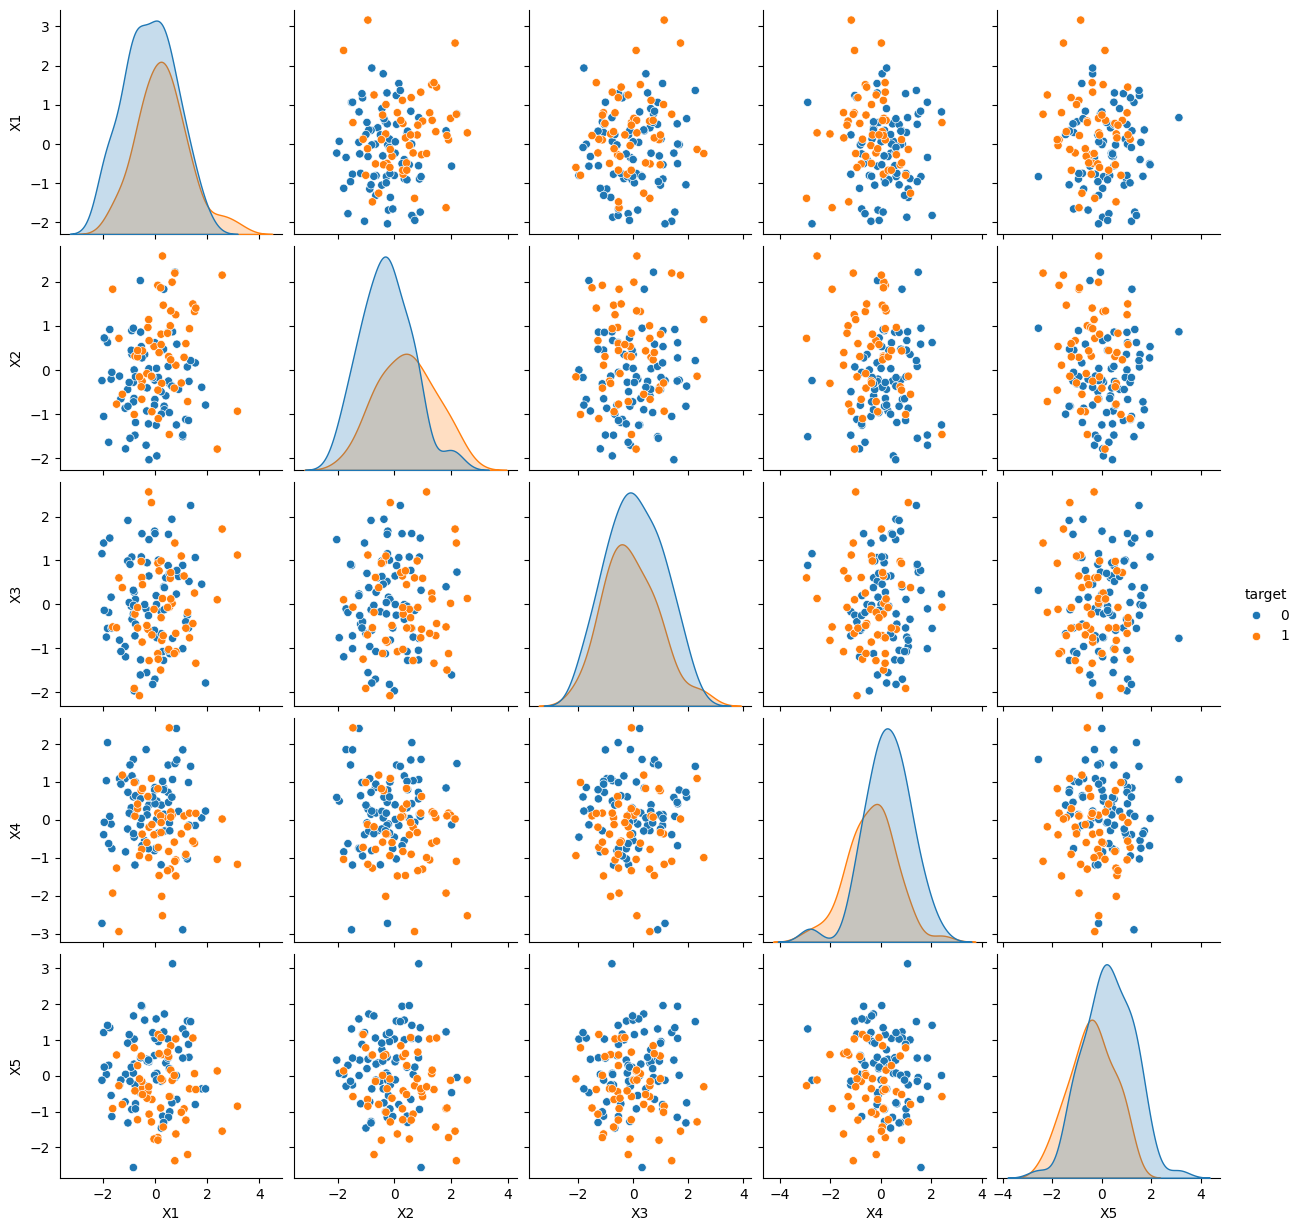

In [1]:
import pandas as pd
import random
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning

#Suppress UndefinedMetricWarning because one or more classes are not present 
#in the test set during a particular fold of cross-validation, the recall for that 
#class cannot be computed, as it requires both true positives and false negatives. We cannot divide by 0.
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

#Set the seed to have always the same results
random.seed(123)

#Loading the dataset
ecoliDataset = pd.read_csv('ecoli.csv')

#Visualize the first 5 entries of the dataset
ecoliDataset.head(5)

#Apply bootstrap (Resampling the data, with replacement: replace= True)
num_samples = len(ecoliDataset)
ecoliDataset_bootstrap = ecoliDataset.sample(n= num_samples, replace= True)

#Splitting the Features (X1 to X5) from the target variable
X = ecoliDataset[ecoliDataset.columns[:5].tolist()]
target = ecoliDataset['C']
#For both datasets
X_bootstrap = ecoliDataset_bootstrap[ecoliDataset_bootstrap.columns[:5].tolist()]
target_bootstrap = ecoliDataset_bootstrap['C']

#Scale (Normalize) the features
X2 = scale(X)
X3 = scale(X_bootstrap)

#Create the datarame to start plotting the Pairplot
d = pd.DataFrame(X2, columns=X.columns)
d['target'] = target

#Pariplot as seen in lab 
sns.pairplot(d, hue='target')
plt.show()

The bootstrap method is not a mandatory step. The use of bootstrap in this analysis is only meant to understand the robustness of the model and assess how sensible is the model to a particular sample of data, given the small amount of entries.

From now on, we will use our models both on the original dataset and the sampled dataset.

### Application of appropriate Naive Bayes model

In [2]:
from sklearn.naive_bayes import GaussianNB

#Initialize and train the NB classifier as a function, in order to use it
#During the K-Fold Cross validation without repeating redundant lines of code
def trainNB(X, y):
    classifier = GaussianNB()
    classifier.fit(X, y)
    return classifier

### Naive Bayes Classifier


The Naive Bayes Classifier is a machine learning algorihtm that uses the Bayes' theorem. $$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$
Given this formula we can calculate the probability of an event occourring based on a prior event. As a matter of fact, $P(B|A)$ is the posterior proability of the event A given the event B. The classifier itself calculates the highest probability of the classes (0 or 1 in our case study) by analysing a corresponding set of attributes. The Naive Bayes assumes that all the features are indipendent one another for each instance of the target variable.

The model itself uses this formula: $P(C|X) = P(C)  \prod_{i=1}^{n} P(x_i|C)$
where the productory is used to multiply the probability for every feature in the dataset for the given class of the target variable. 

In the `Ecoli.csv` dataset we have continuous numerical features and, with the Pairplot we can visually see that they resamble a Normal distribution. We are using the Gaussian Naive Bayes because is best suited for this analysis, since it assumes that the feature values are distributed according to a Gaussian/Normal distribution.

The Gaussian Naive Bayes, however, has a different formula:

$$P(x_i|y) = \frac{1}{\sqrt{2\pi \sigma_y^2}} e^{-\frac{(x_{i} -\mu_{y})^2}{2\sigma_y^{2}}}$$

where $x_i$ is the value of the feature, $\sigma_y^2$ is the variance of the feature for the examined class and $\mu$ is the mean of the feature for the examined class.

In short, the model in our analysis, given the two classes of the target variable (0 and 1) calculates the probability for each feature two times and then chooses the class with the highest probability.


Even with a small dataset, like the one in use, this model can accomplish good performances. Moreover the Gaussian Naive Bayes has a very low cost in computational power. However this model can have worse performances while dealing with large datasets with real world data since it assumes the Indipendence of the variables. Another problem that this model can manifest is the inabilty to deal with irrelevant features and complex relationships.



### Application of Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression

#Initialize and train the Logistic Regression classifier as a function
#For the same purpose as the NB
def trainLG(X, y):
    classifier = LogisticRegression()
    classifier.fit(X, y)
    return classifier

### Logistic Regression Classifier

The Logistic Regression Classifier is a Machine learning model that uses a logistic function.
$$ P(y = 1|X, \theta) = \frac{1}{1 + e^{-(\theta^T X)}} $$

where $\theta$ are the model's parameters and $X$ represents the features.
In our analysis, we are performing a binary classification and the Logistic Regression Classifier estimates the probability that a feature record of the dataset (observation of features) belongs to either the class 0 or 1. To perform that we need to find a value of $\theta$ such that we can minimise the negative log likelihood. 

$$J(\theta) = -log L(\theta)$$
where
$$L(\theta) = \prod_{i=1}^{n} p_{x_{(i)},\theta}^{y^{(i)}} (1 - p_{x_{(i)},\theta})^{1-y^{(i)}}$$


The decision boundary is the treshold that the model uses to decide the predicted class. For binary classification is set to 0.5. Moreover, this model uses the sigmoid function $\sigma(z) = \frac{1}{1 + e^{-z}}$ to ensure that the probability is between 0 and 1.


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#This function evaluates both the models passed as arguments along with the train and test set
#it's suitable for the k-fold cross validation performed afterwards
def evaluateModels(model, XTest, YTest):
    predictions = model.predict(XTest)
    metrics = {
        #all of the metrics are called from the sklearn library
        #Instead of calculaing the metrics by hand I used the pre-built functions
        #Source: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

        'Accuracy': accuracy_score(YTest, predictions),
        #'Precision': precision_score(YTest, predictions, average='macro'),
        #We could have used average = 'macro' because we have a target class that is binary and unbalanced
        'Precision': precision_score(YTest, predictions),
        'Recall': recall_score(YTest, predictions),
        'F1-Score': f1_score(YTest, predictions)
    
    }
    confMatrix = confusion_matrix(YTest, predictions)
    return metrics, confMatrix

### Confusion Matrix

The confusion matrix is a useful tool to visualize the quantity and quality of instances predicted by the model.
The components are:

* True Positive (TP): Instances where the model correctly predicts the positive class. It's in the upper left corner.
* True Negatives (TN):In the bottom right corner there are all the negative correct predictions.
* False Positive (FP): also known ad type 1 error, these are the instances where the model incorrectly predicted the positive class. They are in the upper right corner.
* False Negative (FN): also known as type 2 error, these are the instances of incorrectly predicted negative class. They are in the bottom left corner.



### Evaluation Metrics

The Metrics that are being used in this analysis are: Accuracy, Precision, Recall, F1-score.


**Accuracy**
$$\text{Accuracy} = \frac{TP}{\text{TP+TN+FP+FN}}$$
Accuracy is the correctly predicted observations (True Positives) over the total observations. A hight accuracy score says that the model is particularly accurate to identify true positive instances. This metric however n be misleading when dealing with unbalanced classes.

**Precision**

$$\text{Precision} = \frac{TP}{TP + FP}$$

Precision is the True positive instances over the sum of True positives and False positives. A low score or Precision indicates a high amounts of False positives. Depending on the Business Requirements the False positives might be crucual to detect.


**Recall**

$$\text{Recall} = \frac{TP}{TP +FN}$$

The Recall metric indicates the correctly predicted instances over True positives and False negatives. If this score is high, we have a low amount of False negatives.



**F1 Score**
$$ \text{F1 Score} = 2 \frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$$
F1 score is a metric that takes into considerarion a balance between the precision and recall. The F1 score calculates the harmonic mean between the two metrics.This metric is particularly useful when we are dealing with a high cost of False positives and Negatives, like in our case study where we are dealing with medical data.


In [17]:
from sklearn.metrics import roc_curve, auc

def plotROC(y_true, y_probabilities, plot_titolo):
    #Use the roc_curve function to calculate FP rate and TP rate over different tresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_probabilities)
    #Get the Area under the curve
    roc_auc_value = auc(fpr, tpr)

    # Creating the plot
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, linestyle='-', label=f'Receiver Operating Characteristic Curve (area = {roc_auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random model')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(plot_titolo)
    plt.legend(loc="lower right")
    plt.xlabel('False Positives Rate')
    plt.ylabel('True Positives Rate')
    plt.grid(True)
    plt.show()

The Receiver Operating Characteristic (ROC) Curve is a tool to visualize and confront the True positive rate (on the y axis) and the False positive rate (on the x axis) of a model. This plot shows a curve, if the curve is closer to the upper left corner, the model has a high True positive rate. If a model has the curve closer to the Main diagonal, it indicates that the model is guerring randomly.

### K-Fold Cross Validation

When valuating the performance of a model, it's important to validate the results by using a validation tecnique. In this case I'm using the K-FOld Cross Validation. This tecnique splits the dataset into 'K' subsets called "Folds", where K is an integer number (5 in our case). The model is then iteratively trained on K-1 folds of the datasets, with the last fold for the test set. After that, the training and testing is performed using a different fold for test and the ramaining K-1 folds for the test. This is done K times to ensure that the model sees all the data al least once. The performance is evalued with metrics such as Precision or Accuracy, then averaged out by the number of folds(in our case divided by 5) to have a final score of how the model performs in general. The K-fold is a useful tool to really see how the model behaves by reducing the impact of a biased test set, expecially in smal datasets like the one in use.

Naive Bayes Results: 
Average Metrics for Original Dataset with NB:  {'Accuracy': 0.728, 'Precision': 0.7477777777777778, 'Recall': 0.5999999999999999, 'F1-Score': 0.6486015037593986}
Average Metrics for Bootstrap Dataset with NB:  {'Accuracy': 0.696923076923077, 'Precision': 0.6122655122655123, 'Recall': 0.5427272727272727, 'F1-Score': 0.5637426900584795}


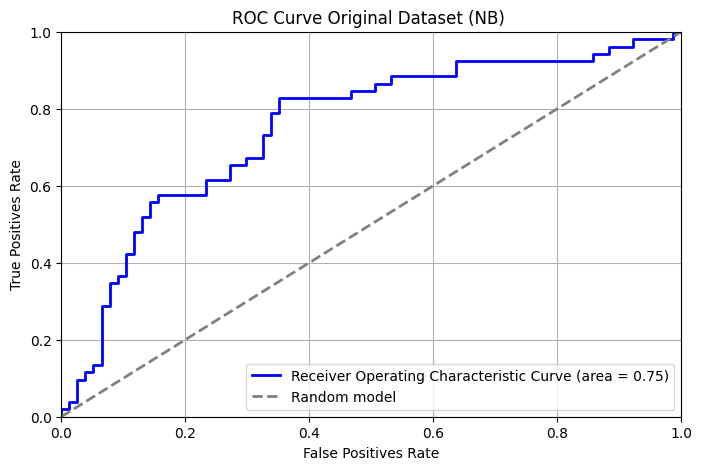

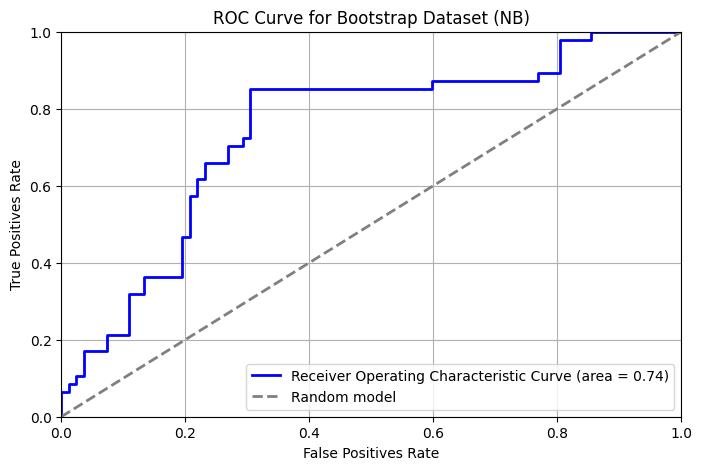




Logistic Regression Results: 
Metrics for Original Dataset (LR):  {'Accuracy': 0.728, 'Precision': 0.7028127428127428, 'Recall': 0.6555555555555556, 'F1-Score': 0.6616758893280632}
Metrics for Bootstrap Dataset (LR) :  {'Accuracy': 0.7123076923076923, 'Precision': 0.6333333333333334, 'Recall': 0.5559090909090909, 'F1-Score': 0.5872377020983832}


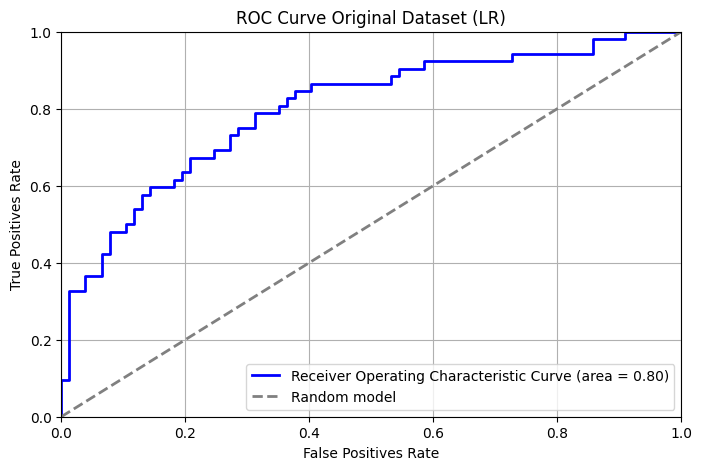

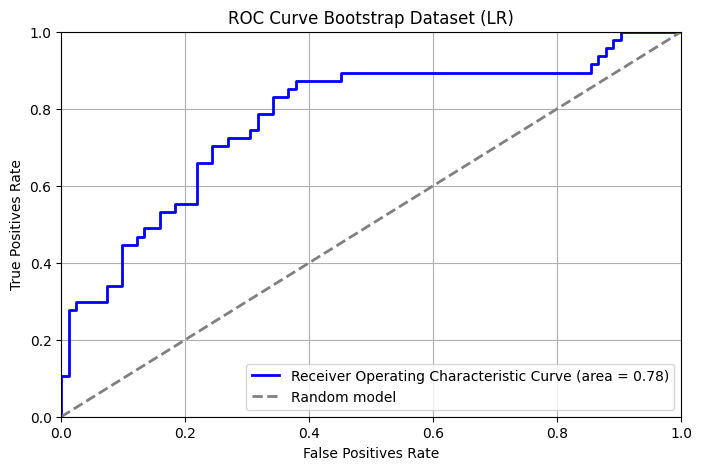

Model Comparison
Performances on original Dataset: 

Naive Bayes:  {'Accuracy': 0.728, 'Precision': 0.7477777777777778, 'Recall': 0.5999999999999999, 'F1-Score': 0.6486015037593986}
Logistic Regression:  {'Accuracy': 0.728, 'Precision': 0.7028127428127428, 'Recall': 0.6555555555555556, 'F1-Score': 0.6616758893280632}
Performances on Bootstrap Dataset: 

Naive Bayes:  {'Accuracy': 0.696923076923077, 'Precision': 0.6122655122655123, 'Recall': 0.5427272727272727, 'F1-Score': 0.5637426900584795}
Logistic Regression:  {'Accuracy': 0.7123076923076923, 'Precision': 0.6333333333333334, 'Recall': 0.5559090909090909, 'F1-Score': 0.5872377020983832}


In [21]:
from sklearn.model_selection import KFold
# Initialize K-Fold cross-validation
KFoldCV = KFold(n_splits=5, shuffle=True, random_state=123)
#I set 5 splits to divide the train and test folds to 80-20
#The parameter Shuffle = True is set to make sure that the folds are made of shuffled entries of the dataset
#This enhances the performances I had previously when I was missing that parameter
#The random state is set to 123 (an integer number) to ensure reproducibility
"""
Below are declared all the lists used in the code, even though the lists are plenty
they are used to store all the metrics because I wanted to have them separate in case I needed to make more 
Specific analysis. All the lists are both for NB and Logistic regression models in order to store
the metrics, the confusion matrix values and the predictions for the ROC curve.
I have lists because in this way i can make a cumulative Confusion matrix for all the folds.
I find that having more lists instead of 5 plots per model seems more professional.

"""
#NB lists
nb_metrics_original, nb_metrics_bootstrap, nb_conf_matrices_original, nb_conf_matrices_bootstrap = [], [], [], []
#LR lists
LR_metrics_original, LR_metrics_bootstrap, LR_conf_matrices_original, LR_conf_matrices_bootstrap = [], [], [], []
#Lists for ROC curve
nb_y_true_original, nb_y_scores_original, nb_y_true_bootstrap, nb_y_scores_bootstrap = [], [], [],[]
LR_y_true_original, LR_y_scores_original,  LR_y_true_bootstrap, LR_y_scores_bootstrap = [], [], [], []


#This is the for loop for the K-Fold Cross Validation for both models
for trainIndex1, testIndex1 in KFoldCV.split(X2):
    XTrain, XTest = X2[trainIndex1], X2[testIndex1]
    YTrain, YTest = target.iloc[trainIndex1], target.iloc[testIndex1]
    XTrainBoot, XTestBoot = X3[trainIndex1], X3[testIndex1]
    YTrainBoot, YTestBoot = target_bootstrap.iloc[trainIndex1], target_bootstrap.iloc[testIndex1]

    #This is the section where I train and evaluate the NB classifier
    #I use lists to store the values for further uses like plotting or aggregation
    NBOriginalModel = trainNB(XTrain, YTrain)
    nb_predictions_original = NBOriginalModel.predict(XTest)
    nb_metrics_original.append(evaluateModels(NBOriginalModel, XTest, YTest)[0])
    nb_conf_matrices_original.append(confusion_matrix(YTest, nb_predictions_original))
    nb_y_true_original.append(YTest)
    nb_y_scores_original.append(NBOriginalModel.predict_proba(XTest)[:, 1])
    #Same thing applies to the Bootstrap Dataset
    NBBootstrapModel = trainNB(XTrainBoot, YTrainBoot)
    nb_predictions_bootstrap = NBBootstrapModel.predict(XTestBoot)
    nb_metrics_bootstrap.append(evaluateModels(NBBootstrapModel, XTestBoot, YTestBoot)[0])
    nb_conf_matrices_bootstrap.append(confusion_matrix(YTestBoot, nb_predictions_bootstrap))
    nb_y_true_bootstrap.append(YTestBoot)
    nb_y_scores_bootstrap.append(NBBootstrapModel.predict_proba(XTestBoot)[:, 1])

    #This is the section where I train and evaluate the LR Classifier
    #Here, again, I use lists to store teh results
    LROriginalModel = trainLG(XTrain, YTrain)
    lr_predictions_original = LROriginalModel.predict(XTest)
    LR_metrics_original.append(evaluateModels(LROriginalModel, XTest, YTest)[0])
    LR_conf_matrices_original.append(confusion_matrix(YTest, lr_predictions_original))
    LR_y_true_original.append(YTest)
    LR_y_scores_original.append(LROriginalModel.predict_proba(XTest)[:, 1])

    LRBootstrapModel = trainLG(XTrainBoot, YTrainBoot)
    lr_predictions_bootstrap = LRBootstrapModel.predict(XTestBoot)
    LR_metrics_bootstrap.append(evaluateModels(LRBootstrapModel, XTestBoot, YTestBoot)[0])
    LR_conf_matrices_bootstrap.append(confusion_matrix(YTestBoot, lr_predictions_bootstrap))
    LR_y_true_bootstrap.append(YTestBoot)
    LR_y_scores_bootstrap.append(LRBootstrapModel.predict_proba(XTestBoot)[:, 1])


#I am aggregating the results 
#My first thought was plotting the ROC curve and the Results for each fold of the K-Fold
#However after some experiments I decided to have less plots and try to concatenate the results
#To show everything at once
nb_y_true_original = np.concatenate(nb_y_true_original)
nb_y_scores_original = np.concatenate(nb_y_scores_original)
nb_y_true_bootstrap = np.concatenate(nb_y_true_bootstrap)
nb_y_scores_bootstrap = np.concatenate(nb_y_scores_bootstrap)
LR_y_true_original = np.concatenate(LR_y_true_original)
LR_y_true_bootstrap = np.concatenate(LR_y_true_bootstrap)
LR_y_scores_original = np.concatenate(LR_y_scores_original)
LR_y_scores_bootstrap = np.concatenate(LR_y_scores_bootstrap)

#Printing the metrics and the ROC curve for Naive Bayes
print("Naive Bayes Results: ")
average_nb_metrics_original = {k: np.mean([m[k] for m in nb_metrics_original]) for k in nb_metrics_original[0].keys()}
average_nb_metrics_bootstrap = {k: np.mean([m[k] for m in nb_metrics_bootstrap]) for k in nb_metrics_bootstrap[0].keys()}
print("Average Metrics for Original Dataset with NB: ", average_nb_metrics_original)
print("Average Metrics for Bootstrap Dataset with NB: ", average_nb_metrics_bootstrap)
plotROC(nb_y_true_original, nb_y_scores_original, 'ROC Curve Original Dataset (NB) ')
plotROC(nb_y_true_bootstrap, nb_y_scores_bootstrap, 'ROC Curve for Bootstrap Dataset (NB)')

print("\n\n")

#Printing the results for Logistic regression alongside the RoC curve
print("Logistic Regression Results: ")
average_LR_metrics_original = {k: np.mean([m[k] for m in LR_metrics_original]) for k in LR_metrics_original[0].keys()}
average_LR_metrics_bootstrap = {k: np.mean([m[k] for m in LR_metrics_bootstrap]) for k in LR_metrics_bootstrap[0].keys()}
print("Metrics for Original Dataset (LR): ", average_LR_metrics_original)
print("Metrics for Bootstrap Dataset (LR) : ", average_LR_metrics_bootstrap)
plotROC(LR_y_true_original, LR_y_scores_original, 'ROC Curve Original Dataset (LR)')
plotROC(LR_y_true_bootstrap, LR_y_scores_bootstrap, 'ROC Curve Bootstrap Dataset (LR)')

#Model comparison (non graphical)
print("Model Comparison")
print("Performances on original Dataset: \n")
print("Naive Bayes: ", average_nb_metrics_original)
print("Logistic Regression: ", average_LR_metrics_original)

print("Performances on Bootstrap Dataset: \n")
print("Naive Bayes: ", average_nb_metrics_bootstrap)
print("Logistic Regression: ", average_LR_metrics_bootstrap)


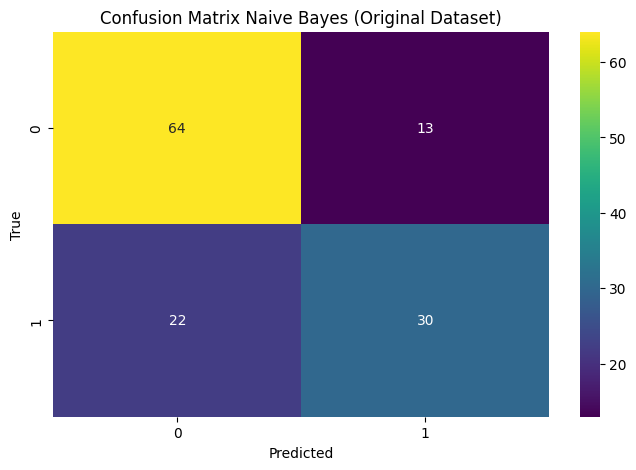

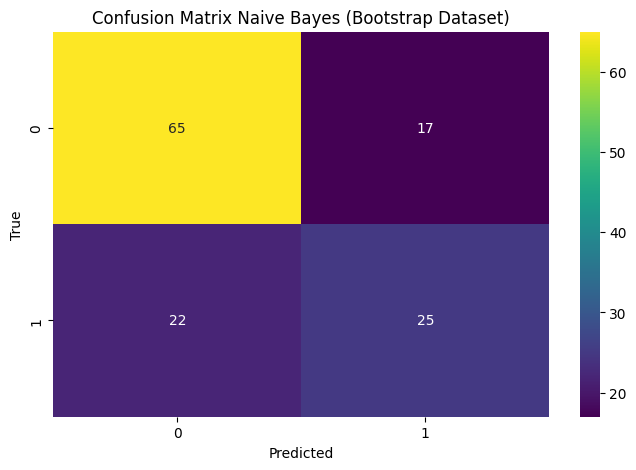

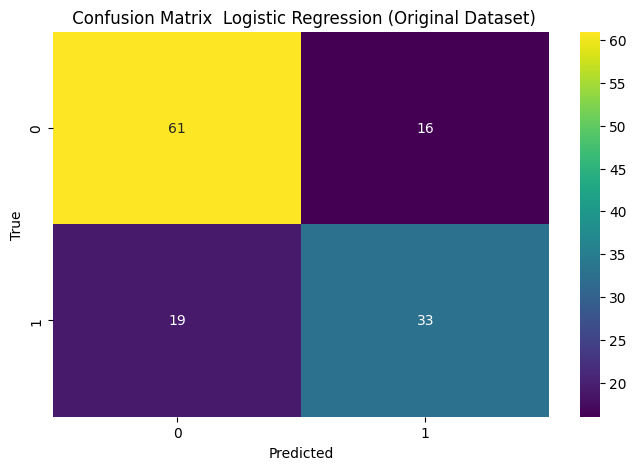

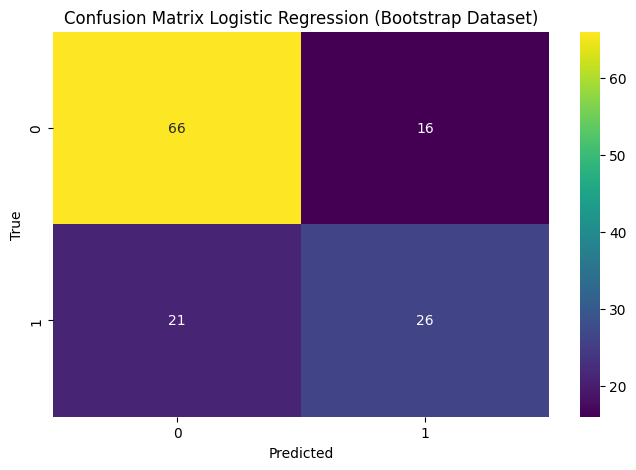

In [23]:
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='viridis')
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

#Aggregating the results for the confusion Matrix
cumulative_nb_conf_matrix_original = sum(nb_conf_matrices_original)
cumulative_nb_conf_matrix_bootstrap = sum(nb_conf_matrices_bootstrap)
cumulative_lr_conf_matrix_original = sum(LR_conf_matrices_original)
cumulative_lr_conf_matrix_bootstrap = sum(LR_conf_matrices_bootstrap)

#PLotting all of the confusion matrices (2 for NB and 2 for LR)
plot_confusion_matrix(cumulative_nb_conf_matrix_original, 'Confusion Matrix Naive Bayes (Original Dataset)')
plot_confusion_matrix(cumulative_nb_conf_matrix_bootstrap, 'Confusion Matrix Naive Bayes (Bootstrap Dataset)')
plot_confusion_matrix(cumulative_lr_conf_matrix_original, ' Confusion Matrix  Logistic Regression (Original Dataset)')
plot_confusion_matrix(cumulative_lr_conf_matrix_bootstrap, 'Confusion Matrix Logistic Regression (Bootstrap Dataset)')


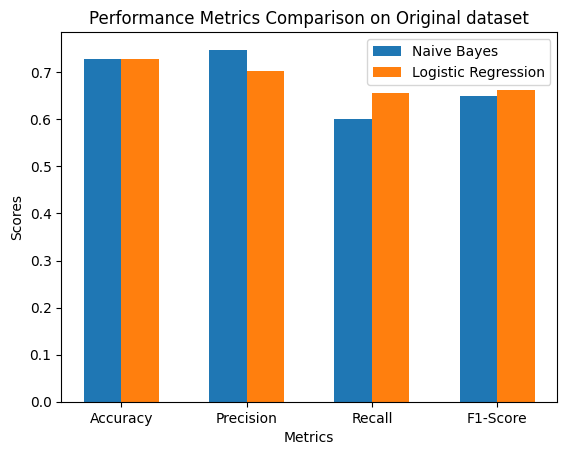

In [25]:
#Plotting the bar charts to confront the models visually
performance_metrics = ['Accuracy', 'Precision', 'Recall','F1-Score']
nb_metrics = [average_nb_metrics_original[metric] for metric in performance_metrics]
LR_metrics = [average_LR_metrics_original[metric] for metric in performance_metrics]

x = np.arange(len(performance_metrics))
width = 0.3
plt.bar(x - width/2, nb_metrics, width, label='Naive Bayes')
plt.bar(x + width/2, LR_metrics, width, label='Logistic Regression')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics Comparison on Original dataset')
plt.xticks(x, performance_metrics)
plt.legend()
plt.show()

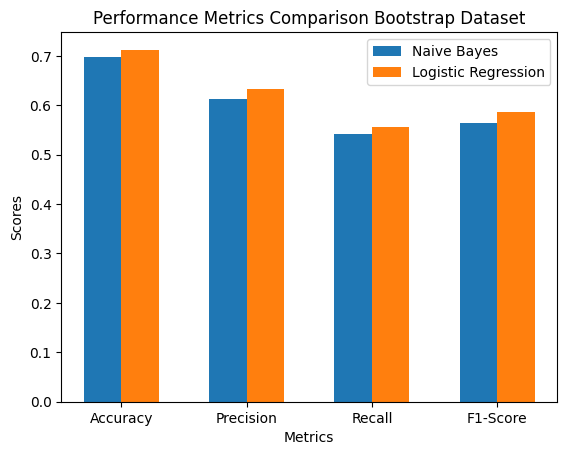

In [20]:
#Bar chart for Bootstrap dataset
nb_metrics_bootstrap = [average_nb_metrics_bootstrap[metric] for metric in performance_metrics]
LR_metrics_bootstrap = [average_LR_metrics_bootstrap[metric] for metric in performance_metrics]

plt.bar(x - width/2, nb_metrics_bootstrap, width, label='Naive Bayes')
plt.bar(x + width/2, LR_metrics_bootstrap, width, label='Logistic Regression')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics Comparison Bootstrap Dataset')
plt.xticks(x, performance_metrics)
plt.legend()
plt.show()

### Final Considerations 

We have a slight difference in performance between the two models on the two datasets. The change in performance of the models over the two datasets can be attributed to the way sampling works ad how it facilitates one model over another. The original dataset had an inbalance in the target variable. The bootstrap can expand or mitigate this gap, resulting in better or worse performances. The bootstrap also can modify the distribution of the data. Since bot the Gaussian Naive Bayes and the Logistic Regression work well with a normal distributes datasets, this method of sampling may have benefitted the models. We can say that these models are sensible to the distribution of data.

Overall the difference of performance of the two models is as follows:

**Original Dataset**

* Precision: Naive Bayes is higher by 0.045.
* Accuracy: There is no difference in accuracy, both models have an accuracy of 0.728.
* Recall: Logistic Regression is higher by 0.055.
* F1-Score: Logistic Regression is higher by 0.013. The difference is insignificant.

**Bootstrap Dataset**

* Precision: Logistic Regression is higher by 0.021.
* Accuracy: Logistic Regression is higher by 0.015.
* Recall:  Logistic Regression is higher by 0.013.
* F1-Score: Logistic Regression is higher by 0.023.

The area under the curve of the ROC plot is almost identical, with a minor difference of 0.02.

Overall the performance for the two models is similar, with minor differences. The Logistic regression performs better that the Naive bayes on the bootstrap dataset and -except for Precision - also on the original dataset.

The two models perform better on the Original dataset than the Bootstrap dataset. The experiment of using the boostrap to improe the performances of the model is unsuccessful in this instance.

In conclusion, we can rely on the Logistic regression model to perform correct predictions on the original dataset 65 to 70% of the times.
